In [125]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import re

from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import RandomizedSearchCV

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.preprocessing import LabelEncoder

In [126]:
# Load datasets
train_data = pd.read_csv("dataset/train.csv")
test_data = pd.read_csv("dataset/test.csv")

### EDA

In [127]:
# Explore data
train_data.head().T

,0,1,2,3,4
PassengerId,1,2,3,4,5
Survived,0,1,1,1,0
Pclass,3,1,3,1,3
Name,"Braund, Mr. Owen Harris","Cumings, Mrs. John Bradley (Florence Briggs Th...","Heikkinen, Miss. Laina","Futrelle, Mrs. Jacques Heath (Lily May Peel)","Allen, Mr. William Henry"
Sex,male,female,female,female,male
Age,22.0,38.0,26.0,35.0,35.0
SibSp,1,1,0,1,0
Parch,0,0,0,0,0
Ticket,A/5 21171,PC 17599,STON/O2. 3101282,113803,373450
Fare,7.25,71.2833,7.925,53.1,8.05


In [128]:
# Explore data
test_data.head().T

,0,1,2,3,4
PassengerId,892,893,894,895,896
Pclass,3,3,2,3,3
Name,"Kelly, Mr. James","Wilkes, Mrs. James (Ellen Needs)","Myles, Mr. Thomas Francis","Wirz, Mr. Albert","Hirvonen, Mrs. Alexander (Helga E Lindqvist)"
Sex,male,female,male,male,female
Age,34.5,47.0,62.0,27.0,22.0
SibSp,0,1,0,0,1
Parch,0,0,0,0,1
Ticket,330911,363272,240276,315154,3101298
Fare,7.8292,7.0,9.6875,8.6625,12.2875
Cabin,NaN,NaN,NaN,NaN,NaN


In [129]:
# Explore data
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [130]:
# Explore data
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.1+ KB


### Further EDA

In [131]:
import re

def extract_title(name):
    """
    Extract the title from a person's name.
    """
    title_search = re.search(r' ([A-Za-z]+)\.', name)
    if title_search:
        return title_search.group(1)
    
    return 'Unknown'

In [132]:
def prepare_data_for_modeling(data):
    """
    Prepare the data by handling non-numeric columns and creating new features.
    """
    # Create a copy of the data
    df = data.copy()
    
    # Drop columns that aren't useful for modeling
    columns_to_drop = ['Ticket', 'Cabin']
    df = df.drop([col for col in columns_to_drop if col in df.columns], axis=1)
    
    # Convert categorical variables
    if 'Sex' in df.columns:
        df['Sex'] = df['Sex'].map({'male': 1, 'female': 0})
    if 'Embarked' in df.columns:
        df['Embarked'] = pd.Categorical(df['Embarked']).codes
    
    # Extract title from name
    if 'Name' in df.columns:
        df['Title'] = df['Name'].apply(extract_title)
        df['Title'] = pd.Categorical(df['Title']).codes
        df = df.drop('Name', axis=1)
    
    # Handle any remaining non-numeric columns
    for column in df.select_dtypes(exclude=['int64', 'float64']).columns:
        if column not in ['Survived']:  # Keep Survived as is
            df[column] = pd.Categorical(df[column]).codes
            
    return df

### Feature Engineering

In [133]:
def analyze_feature_importance(train_data):
    """
    Analyze which features correlate most strongly with survival.
    """
    # Create a copy of the data
    df = train_data.copy()
    
    # Convert categorical variables to numeric
    categorical_features = ['Sex', 'Embarked', 'Title']
    for feature in categorical_features:
        if feature in df.columns:
            df[feature] = pd.Categorical(df[feature]).codes
    
    # Select only numeric columns
    numeric_columns = df.select_dtypes(include=['int64', 'float64']).columns
    
    # Calculate correlations with Survived for numeric columns only
    correlations = df[numeric_columns].corr()['Survived'].sort_values(ascending=False)
    
    # Create correlation plot
    plt.figure(figsize=(12, 6))
    correlations.drop('Survived').plot(kind='bar')
    plt.title('Feature Correlations with Survival')
    plt.xlabel('Features')
    plt.ylabel('Correlation Coefficient')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    
    # Create correlation heatmap
    plt.figure(figsize=(12, 8))
    sns.heatmap(df[numeric_columns].corr(), 
                annot=True, 
                cmap='RdBu', 
                center=0,
                fmt='.2f')
    plt.title('Correlation Heatmap')
    plt.tight_layout()
    plt.show()
    
    # Calculate Spearman rank correlation
    spearman_corr = df[numeric_columns].corr(method='spearman')['Survived'].sort_values(ascending=False)
    print("\nSpearman Rank Correlations:")
    print(spearman_corr)
    
    return correlations

In [134]:
def plot_feature_importance(model, feature_names):
    """
    Visualize feature importance from the trained model.
    """
    importances = pd.DataFrame({
        'feature': feature_names,
        'importance': model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    plt.figure(figsize=(10, 6))
    sns.barplot(data=importances, x='importance', y='feature')
    plt.title('Feature Importance')
    plt.xlabel('Importance Score')
    plt.ylabel('Feature')
    plt.tight_layout()
    plt.show()
    
    return importances

### Performing hyperparameter tuning - XGBoost

In [135]:
def tune_xgboost_model(X_train, y_train):
    """
    Perform hyperparameter tuning for XGBoost using RandomizedSearchCV.
    """
    param_dist = {
        'n_estimators': [100, 200, 300, 400, 500],
        'max_depth': [3, 5, 7, 10],
        'learning_rate': [0.01, 0.05, 0.1, 0.2],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'gamma': [0, 1, 5],
        'reg_alpha': [0, 0.1, 1],
        'reg_lambda': [1, 1.5, 2]
    }

    # Initialize XGBoost model
    # xgb = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
    xgb  = XGBClassifier()

    # Perform random search
    random_search = RandomizedSearchCV(
        estimator=xgb,
        param_distributions=param_dist,
        n_iter=20,
        cv=5,
        random_state=42,
        n_jobs=-1,
        verbose=1
    )

    # Fit random search
    random_search.fit(X_train, y_train)

    print("\nBest parameters for XGBoost:")
    print(random_search.best_params_)
    print("\nBest cross-validation score:", random_search.best_score_)

    return random_search.best_estimator_

### Performing hyperparameter tuning - LightGBM

In [136]:
def tune_lightgbm_model(X_train, y_train):
    """
    Perform hyperparameter tuning for LightGBM using RandomizedSearchCV.
    """
    param_dist = {
        'n_estimators': [100, 200, 300, 400, 500],
        'max_depth': [3, 5, 7, 10, -1],
        'learning_rate': [0.01, 0.05, 0.1, 0.2],
        'num_leaves': [20, 31, 40, 50],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'min_child_samples': [10, 20, 30],
        'reg_alpha': [0, 0.1, 1],
        'reg_lambda': [1, 1.5, 2]
    }

    # Initialize LightGBM model
    # lgbm = LGBMClassifier(random_state=42)
    lgbm = LGBMClassifier()

    # Perform random search
    random_search = RandomizedSearchCV(
        estimator=lgbm,
        param_distributions=param_dist,
        n_iter=20,
        cv=5,
        random_state=42,
        n_jobs=-1,
        verbose=1
    )

    # Fit random search
    random_search.fit(X_train, y_train)

    print("\nBest parameters for LightGBM:")
    print(random_search.best_params_)
    print("\nBest cross-validation score:", random_search.best_score_)

    return random_search.best_estimator_

### Training XGBoost model

In [137]:
def train_xgboost_model(X_train, X_val, y_train, y_val):
    """
    Train an XGBoost model and evaluate its performance
    """
    # Initialize XGBoost model
    # xgb_model = XGBClassifier(objective='binary:logistic', random_state=42)
    xgb_model  = XGBClassifier()
    
    # Train the model
    xgb_model.fit(X_train, y_train)
    
    # Evaluate on validation set
    val_predictions = xgb_model.predict(X_val)
    accuracy = accuracy_score(y_val, val_predictions)
    print(f"\nXGBoost Model Validation Accuracy: {accuracy:.2f}")
    
    return xgb_model

### Training LightGBM model

In [138]:
def train_lightgbm_model(X_train, X_val, y_train, y_val):
    """
    Train a LightGBM model and evaluate its performance
    """
    # Initialize LightGBM model
    # lgbm_model = LGBMClassifier(objective='binary', random_state=42)
    lgbm_model = LGBMClassifier()
    
    
    # Train the model
    lgbm_model.fit(X_train, y_train)
    
    # Evaluate on validation set
    val_predictions = lgbm_model.predict(X_val)
    accuracy = accuracy_score(y_val, val_predictions)
    print(f"\nLightGBM Model Validation Accuracy: {accuracy:.2f}")
    
    return lgbm_model

### Create submission file with predictions

In [139]:
def create_submission(model, test_features, test_data, filename='submission_XXX.csv'):
    """
    Create submission file with predictions
    """
    predictions = model.predict(test_features)
    # Create submission DataFrame
    output = pd.DataFrame({
        'PassengerId': test_data.PassengerId,
        'Survived': predictions
    })
    
    # Save to CSV
    output.to_csv(filename, index=False)
    print(f"\nSubmission saved to {filename}")
    
    return predictions

### main()

In [140]:
def main(train_data, test_data):
    """
    Main function to run the entire pipeline
    """
    import warnings
    warnings.filterwarnings('ignore')
    
    print("Preparing data...")  # EDA
    prepared_train_data = prepare_data_for_modeling(train_data)
    prepared_test_data = prepare_data_for_modeling(test_data)

    print("Analyzing feature importance...")    # EDA
    pearson_correlations = analyze_feature_importance(prepared_train_data)
    print("\nTop Pearson Correlations with Survival:")
    print(pearson_correlations)
    
    print("\nPreparing features...")
    X = prepared_train_data.drop('Survived', axis=1)
    y = prepared_train_data['Survived']
    
    # Split training data for validation
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
    
    print("\nPerforming hyperparameter tuning...")
    # Call the tuning functions
    xgb_model = tune_xgboost_model(X_train, y_train)
    lgbm_model = tune_lightgbm_model(X_train, y_train)

    # Train and evaluate further if needed
    # xgb_model.fit(X_train, y_train)
    # lgbm_model.fit(X_train, y_train)
    
    print("\nTraining XGBoost model...")
    xgb_model = train_xgboost_model(X_train, X_val, y_train, y_val)
    
    print("\nTraining LightGBM model...")
    lgbm_model = train_lightgbm_model(X_train, X_val, y_train, y_val)    
    
    print("\nPreparing test data and generating predictions...")
    prepared_test_data = prepare_data_for_modeling(test_data)

    xgb_predictions = create_submission(xgb_model, prepared_test_data, test_data, filename='submission_xgb.csv')
    lgbm_predictions = create_submission(lgbm_model, prepared_test_data, test_data, filename='submission_lgbm.csv')
    
    return xgb_model, lgbm_model, xgb_predictions, lgbm_predictions
    

Preparing data...
Analyzing feature importance...


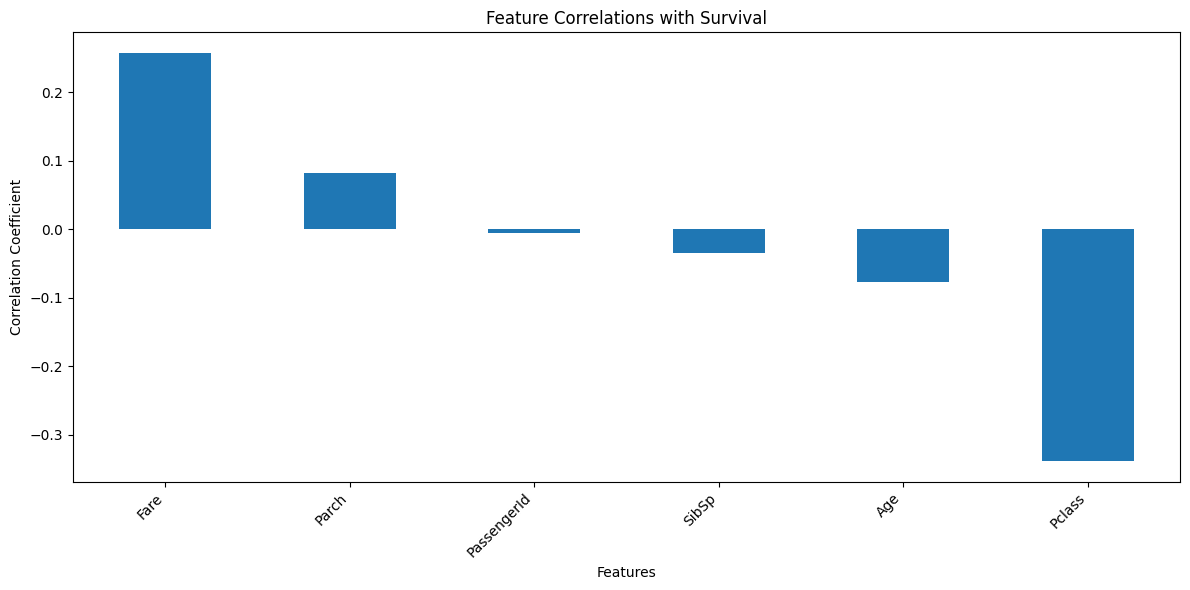

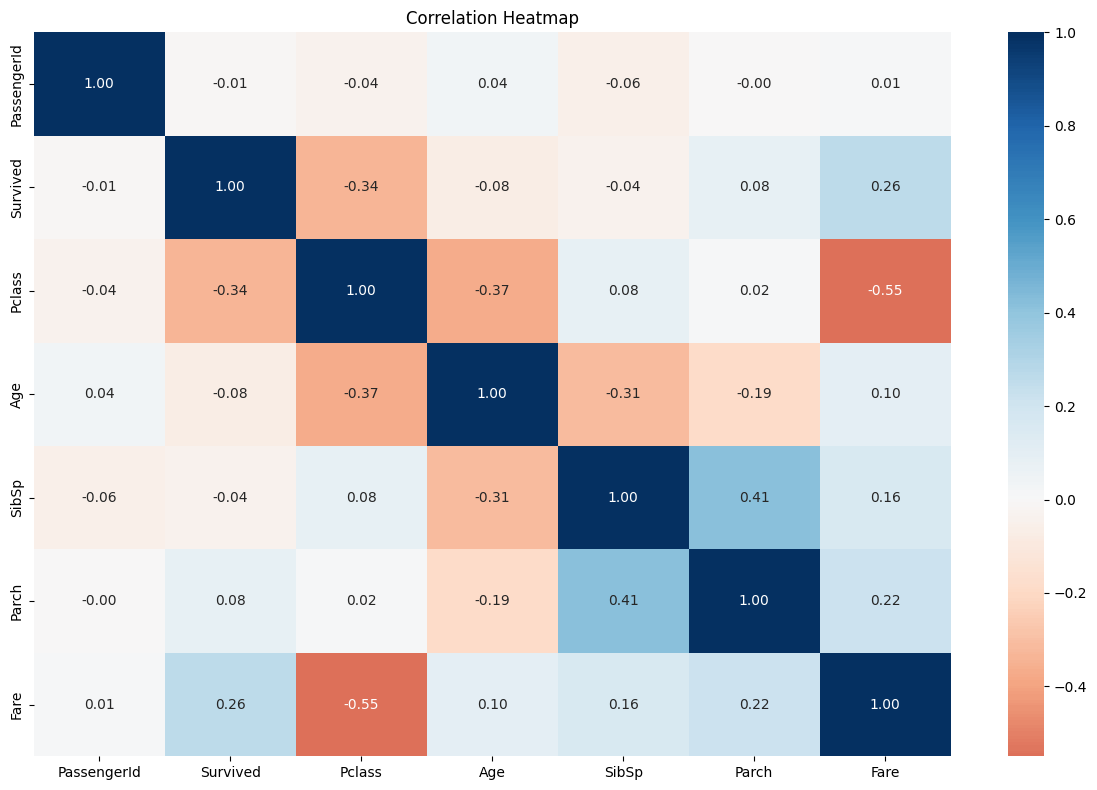


Spearman Rank Correlations:
Survived       1.000000
Fare           0.323736
Parch          0.138266
SibSp          0.088879
PassengerId   -0.005007
Age           -0.052565
Pclass        -0.339668
Name: Survived, dtype: float64

Top Pearson Correlations with Survival:
Survived       1.000000
Fare           0.257307
Parch          0.081629
PassengerId   -0.005007
SibSp         -0.035322
Age           -0.077221
Pclass        -0.338481
Name: Survived, dtype: float64

Preparing features...

Performing hyperparameter tuning...
Fitting 5 folds for each of 20 candidates, totalling 100 fits

Best parameters for XGBoost:
{'subsample': 1.0, 'reg_lambda': 1, 'reg_alpha': 0, 'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.2, 'gamma': 1, 'colsample_bytree': 1.0}

Best cross-validation score: 0.8229587314094357
Fitting 5 folds for each of 20 candidates, totalling 100 fits
[LightGBM] [Info] Number of positive: 268, number of negative: 444
[LightGBM] [Info] Auto-choosing row-wise multi-threadi

In [141]:
xgb_model, lgbm_model, xgb_predictions, lgbm_predictions = main(train_data, test_data)